# Prédiction de la consommation d'électricité en France :

Projet developpement logiciel 

Traîtement des données sur Jupyter Notebook (distribution Anaconda) 

Etude réalisée en language Python 

Source des données : 

[Données de la consommation brute d'électricité du 07 décembre 2014 au 31 mai 2022 (par 1/2 heure)](https://odre.opendatasoft.com/explore/dataset/eco2mix-national-cons-def/table/?disjunctive.nature&sort=-date_heure&refine.date_heure=2015&q.timerange.date_heure=date_heure:%5B2015-12-06T23:00:00Z+TO+2022-05-31T21:59:59Z%5D)

[Données de la consommation brute d'électricité du 01 Juin au 29 novembre 2022 (par 1/4 heure)](https://odre.opendatasoft.com/explore/dataset/eco2mix-national-tr/table/?disjunctive.nature&sort=-date_heure&q.timerange.date_heure=date_heure:%5B2022-05-31T22:00:00Z+TO+2022-11-29T22:59:59Z%5D)

In [52]:
# Librairies nécessaires :

import pandas as pd
import numpy as np
import os #télécharger les données / éviter de re-télécharger à chaque fois
import pooch 
from IPython import get_ipython

from prophet import Prophet 
import time
from datetime import datetime
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact, interactive, fixed, interact_manual 
import matplotlib
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import pylab 
from pylab import rcParams #paramètres de style 
import warnings 
warnings.filterwarnings("ignore") #pour se débarasser des warnings


register_matplotlib_converters()
color_pal = sns.color_palette()
color_pal1 = sns.color_palette("viridis" , as_cmap=True)

%matplotlib inline

In [44]:
#Paramètre de style :
pylab.style.use('fivethirtyeight')
params = {'legend.fontsize': 'x-large',
          'figure.figsize':(20, 6),
          'lines.linewidth': 1.8,
          'axes.labelsize': 'x-large',
          'axes.titleweight': 'bold',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)

In [45]:
# Versions utilisées :
print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Matplotlib : " + str(matplotlib.__version__))
print("Seaborn : " + str(sns.__version__))

Pandas : 1.4.2
Numpy : 1.22.4
Matplotlib : 3.5.1
Seaborn : 0.11.2


## 1- Création de la base de données :

### 1.1.1 - Téléchargement des données :

In [5]:
#Création du fichier 'consommation_elc.csv' à partit de l'url (url1 : 7 Décembre 2014 -> 31 Mai 2022)

url1 = "https://odre.opendatasoft.com/explore/dataset/eco2mix-national-cons-def/download/?format=csv&disjunctive.nature=true&q=date_heure:%5B2014-12-07T23:00:00Z+TO+2022-11-08T22:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"
path_target = './consommation_elec.csv'
path, fname = os.path.split(path_target)
pooch.retrieve(url1, path=path, fname=fname, known_hash=None)

'C:\\Users\\sarah\\OneDrive\\Documents\\Projet\\consommation_elec.csv'

In [46]:
# Chargement du dataset "consommation_elec.csv":
data = pd.read_csv("consommation_elec.csv", delimiter=";", comment="#", na_values="n/d",parse_dates=['Date et Heure'], converters={'heure' : str})
data

,Périmètre,Nature,Date,Heure,Date et Heure,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),...,Gaz - TAC (MW),Gaz - Cogénération (MW),Gaz - CCG (MW),Gaz - Autres (MW),Hydraulique - Fil de l'eau + éclusée (MW),Hydraulique - Lacs (MW),Hydraulique - STEP turbinage (MW),Bioénergies - Déchets (MW),Bioénergies - Biomasse (MW),Bioénergies - Biogaz (MW)
0,France,Données définitives,2015-08-23,11:00,2015-08-23 11:00:00+02:00,39414.0,39300,39500,216.0,-5.0,...,-1.0,250.0,252.0,29.0,2261.0,729.0,358.0,473.0,226.0,201.0
1,France,Données définitives,2015-08-23,11:15,2015-08-23 11:15:00+02:00,NaN,39600,39800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,France,Données définitives,2015-08-23,13:15,2015-08-23 13:15:00+02:00,NaN,41150,42300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,France,Données définitives,2015-08-23,14:15,2015-08-23 14:15:00+02:00,NaN,38850,39850,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,France,Données définitives,2015-08-23,17:45,2015-08-23 17:45:00+02:00,NaN,36750,37000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262267,France,Données définitives,2015-02-09,17:00,2015-02-09 17:00:00+01:00,73150.0,73600,72900,334.0,2598.0,...,8.0,2685.0,3669.0,112.0,5060.0,2605.0,325.0,507.0,217.0,217.0
262268,France,Données définitives,2015-02-09,22:30,2015-02-09 22:30:00+01:00,73416.0,74600,74600,337.0,2472.0,...,8.0,2654.0,3748.0,112.0,5162.0,2652.0,252.0,510.0,208.0,218.0
262269,France,Données définitives,2015-02-09,23:00,2015-02-09 23:00:00+01:00,76328.0,77500,77500,335.0,2625.0,...,8.0,2651.0,3765.0,112.0,5254.0,4004.0,1183.0,509.0,211.0,218.0
262270,France,Données définitives,2015-02-10,01:30,2015-02-10 01:30:00+01:00,72610.0,73300,72600,336.0,2594.0,...,7.0,2541.0,2227.0,112.0,4442.0,3143.0,90.0,518.0,214.0,218.0


### 1.1.2 - Nettoyage des données :

In [5]:
#Restriction des données sur les modalités "date et heure" et "consommation" 
dfr = data.copy()
dfr = data[['Date et Heure', 'Consommation (MW)']]                   
dfr = dfr.rename(columns={'Date et Heure' : 'ds', 'Consommation (MW)' : 'y'})
dfr = dfr.dropna() #supprimer les valeurs aberrantes 
dfr['ds'] = pd.to_datetime(dfr['ds'] , utc=True).dt.tz_localize(None)  #convertir l'objet 'ds' en datetime / supprimer timezone
dfr = dfr.sort_values(by = 'ds', ascending = True) #ordonner la colonne 'ds'  dans l'ordre croissant
dfr = dfr.set_index('ds') 

### 1.1.3 - Aperçu des données :

In [6]:
dfr.head(10)

,y
ds,
2014-12-07 23:00:00,65815.0
2014-12-07 23:30:00,64332.0
2014-12-08 00:00:00,61708.0
2014-12-08 00:30:00,61292.0
2014-12-08 01:00:00,60926.0
2014-12-08 01:30:00,60602.0
2014-12-08 02:00:00,58808.0
2014-12-08 02:30:00,57848.0
2014-12-08 03:00:00,56853.0


In [8]:
dfr.index

DatetimeIndex(['2014-12-07 23:00:00', '2014-12-07 23:30:00',
               '2014-12-08 00:00:00', '2014-12-08 00:30:00',
               '2014-12-08 01:00:00', '2014-12-08 01:30:00',
               '2014-12-08 02:00:00', '2014-12-08 02:30:00',
               '2014-12-08 03:00:00', '2014-12-08 03:30:00',
               ...
               '2022-05-31 17:00:00', '2022-05-31 17:30:00',
               '2022-05-31 18:00:00', '2022-05-31 18:30:00',
               '2022-05-31 19:00:00', '2022-05-31 19:30:00',
               '2022-05-31 20:00:00', '2022-05-31 20:30:00',
               '2022-05-31 21:00:00', '2022-05-31 21:30:00'],
              dtype='datetime64[ns]', name='ds', length=131136, freq=None)

### 1.2.1 -  Téléchargement des données : 

In [9]:
#Création du fichier 'consommation_2022.csv' à partit de l'url (url2 : 01 Juin 2022 -> 30 Novembre 2022)
url2="https://odre.opendatasoft.com/explore/dataset/eco2mix-national-tr/download/?format=csv&disjunctive.nature=true&q=date_heure:%5B2022-05-31T22:00:00Z+TO+2022-11-29T22:59:59Z%5D&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"
path_target = './consommation_2022.csv'
path, fname = os.path.split(path_target)
pooch.retrieve(url2, path=path, fname=fname, known_hash=None)

'C:\\Users\\sarah\\OneDrive\\Documents\\Projet\\consommation_2022.csv'

In [7]:
# Chargement du dataset "consommation_2022.csv"
data1 = pd.read_csv("consommation_2022.csv", delimiter=";", comment="#", na_values="n/d", parse_dates=['Date - Heure'], converters={'heure' : str})
data1

,Périmètre,Nature,Date,Heure,Date - Heure,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),...,Hydraulique - Fil de l'eau + éclusée (MW),Hydraulique - Lacs (MW),Hydraulique - STEP turbinage (MW),Bioénergies - Déchets (MW),Bioénergies - Biomasse (MW),Bioénergies - Biogaz (MW),Stockage batterie (MW),Déstockage batterie (MW),Eolien terrestre (MW),Eolien offshore (MW)
0,France,Données temps réel,2022-07-07,11:00,2022-07-07 11:00:00+02:00,51877,52000,51900,226,33,...,3607,1303,454,185,357,280,ND,ND,ND,ND
1,France,Données temps réel,2022-07-07,13:00,2022-07-07 13:00:00+02:00,53604,54200,54600,191,34,...,3379,1359,555,174,358,280,ND,ND,ND,ND
2,France,Données temps réel,2022-07-07,14:30,2022-07-07 14:30:00+02:00,52239,52600,52300,152,35,...,3050,1028,455,166,358,280,ND,ND,ND,ND
3,France,Données temps réel,2022-07-07,15:45,2022-07-07 15:45:00+02:00,50777,50800,50900,152,38,...,2947,1225,216,181,357,280,ND,ND,ND,ND
4,France,Données temps réel,2022-07-07,16:00,2022-07-07 16:00:00+02:00,50768,50500,50800,152,38,...,2936,1257,214,175,357,280,ND,ND,ND,ND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,France,Données temps réel,2022-08-02,03:15,2022-08-02 03:15:00+02:00,36276,36450,36350,138,24,...,2346,485,17,165,315,275,ND,ND,ND,ND
17468,France,Données temps réel,2022-08-02,03:30,2022-08-02 03:30:00+02:00,35862,36100,36000,138,24,...,2385,493,17,164,316,275,ND,ND,ND,ND
17469,France,Données temps réel,2022-08-02,04:15,2022-08-02 04:15:00+02:00,35226,35500,35400,138,23,...,2380,376,17,171,317,275,ND,ND,ND,ND
17470,France,Données temps réel,2022-08-02,05:45,2022-08-02 05:45:00+02:00,36760,37400,37000,138,23,...,2330,493,19,168,317,275,ND,ND,ND,ND


### 1.2.2 - Nettoyage des données :

In [8]:
#Restriction des données sur les modalités "date - heure" et "consommation" 
dfr1 = data1.copy()
dfr1 = data1[['Date - Heure', 'Consommation (MW)']]                   
dfr1 = dfr1.rename(columns={'Date - Heure' : 'ds', 'Consommation (MW)' : 'y'})
dfr1 = dfr1.dropna()
dfr1['ds'] = pd.to_datetime(dfr1['ds'], utc=True).dt.tz_localize(None) #convertir l'objet 'ds' en datetime/ supprimer timezone
dfr1 = dfr1.sort_values(by='ds', ascending=True) 
dfr1 = dfr1.set_index('ds')
dfr1 = dfr1.resample('30T').mean() #aggrégation des données (la moyenne de conso par demi-heure)

### 1.2.3 - Aperçu des données :

In [9]:
dfr1.head()

,y
ds,
2022-05-31 22:00:00,44453.5
2022-05-31 22:30:00,41793.5
2022-05-31 23:00:00,40417.5
2022-05-31 23:30:00,39940.5
2022-06-01 00:00:00,39553.0


### 1.2.4 - Concaténation des dataframes :

In [10]:
df = pd.concat([dfr, dfr1])
df.index

DatetimeIndex(['2014-12-07 23:00:00', '2014-12-07 23:30:00',
               '2014-12-08 00:00:00', '2014-12-08 00:30:00',
               '2014-12-08 01:00:00', '2014-12-08 01:30:00',
               '2014-12-08 02:00:00', '2014-12-08 02:30:00',
               '2014-12-08 03:00:00', '2014-12-08 03:30:00',
               ...
               '2022-11-29 18:00:00', '2022-11-29 18:30:00',
               '2022-11-29 19:00:00', '2022-11-29 19:30:00',
               '2022-11-29 20:00:00', '2022-11-29 20:30:00',
               '2022-11-29 21:00:00', '2022-11-29 21:30:00',
               '2022-11-29 22:00:00', '2022-11-29 22:30:00'],
              dtype='datetime64[ns]', name='ds', length=139874, freq=None)

In [11]:
df.head(10)

,y
ds,
2014-12-07 23:00:00,65815.0
2014-12-07 23:30:00,64332.0
2014-12-08 00:00:00,61708.0
2014-12-08 00:30:00,61292.0
2014-12-08 01:00:00,60926.0
2014-12-08 01:30:00,60602.0
2014-12-08 02:00:00,58808.0
2014-12-08 02:30:00,57848.0
2014-12-08 03:00:00,56853.0


### 1.3.1 - Visualisation des données :

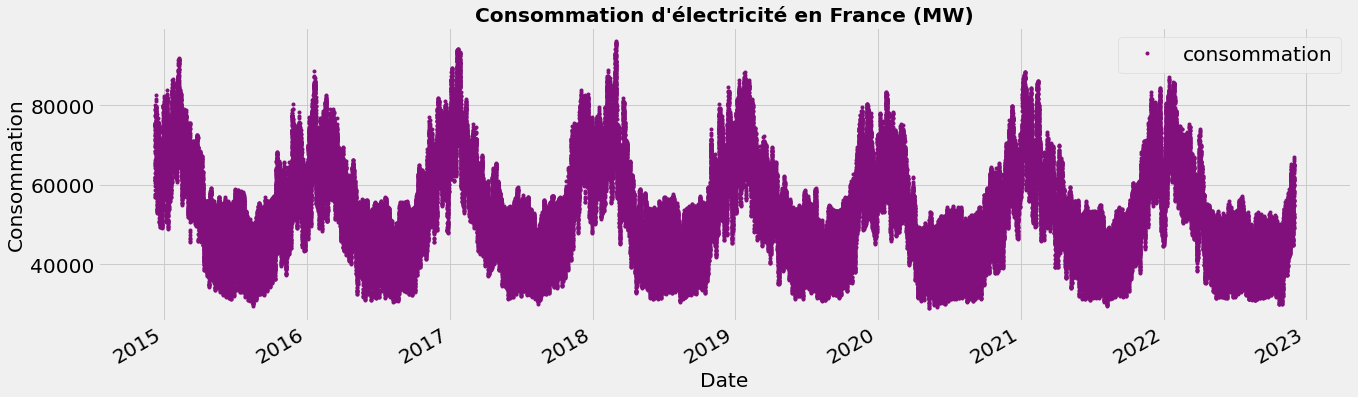

In [17]:
df1 = df.rename(columns = {'y':'consommation'})
df1.plot(style='.', color = color_pal[5])
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.title("Consommation d'électricité en France (MW)")
plt.show()
#plt.savefig('conso_fr.pdf')

### 1.3.2 - Visualisation de la consommation d'éléctricité pour un jour donné :

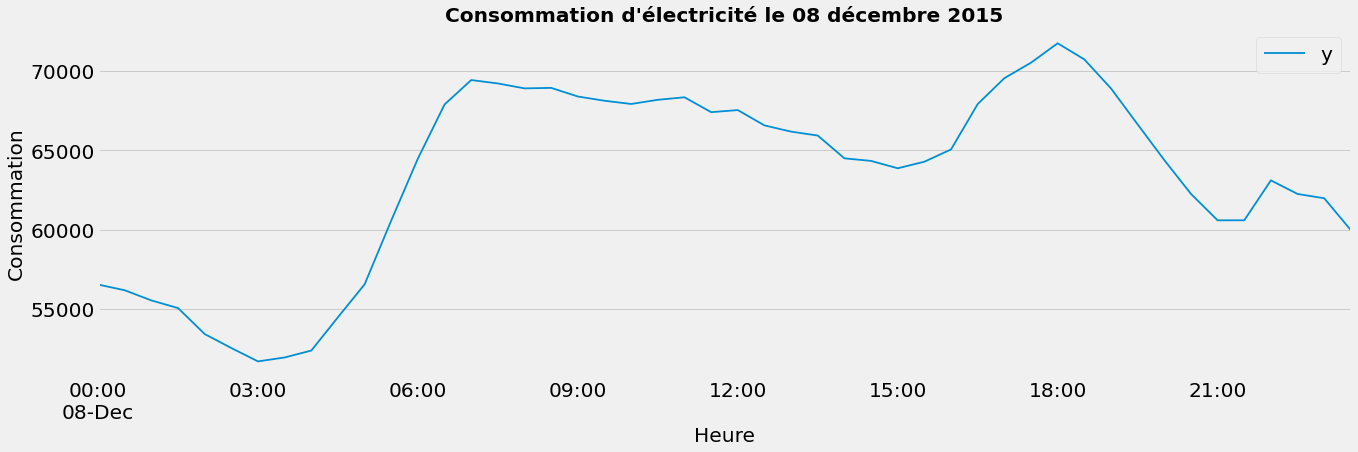

In [25]:
df.loc['2015-12-08'].plot()
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.title("Consommation d'électricité le 08 décembre 2015")
plt.show()

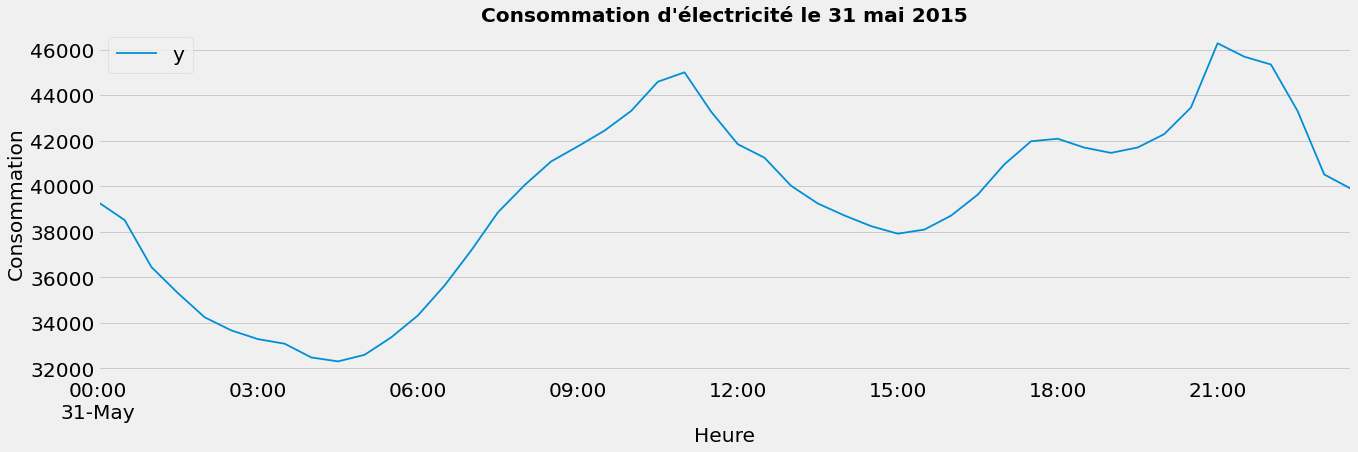

In [27]:
df.loc['2015-05-31'].plot()
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.title("Consommation d'électricité le 31 mai 2015")
plt.show()

### 2- Création du modèle / test :

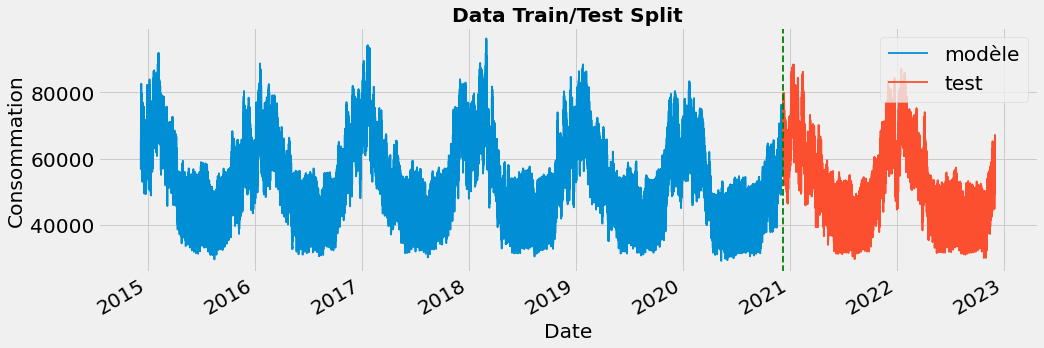

<Figure size 1440x432 with 0 Axes>

In [48]:
train = df.iloc[df.index < '2020-12-08']
test = df.iloc[df.index >= '2020-12-08']

# Visualisation train/test split :
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2020-12-08', color='green', ls='--')
ax.legend(['modèle', 'test'])
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.show()
#plt.savefig("data_train_test.pdf")

In [13]:
df_cons = df.reset_index()
df_cons

,ds,y
0,2014-12-07 23:00:00,65815.0
1,2014-12-07 23:30:00,64332.0
2,2014-12-08 00:00:00,61708.0
3,2014-12-08 00:30:00,61292.0
4,2014-12-08 01:00:00,60926.0
...,...,...
139869,2022-11-29 20:30:00,58182.0
139870,2022-11-29 21:00:00,57275.5
139871,2022-11-29 21:30:00,58408.5
139872,2022-11-29 22:00:00,58450.0


In [17]:
#train model : 
m = Prophet()
m.fit(df_cons)
future = m.make_future_dataframe(periods=2*48, freq='30min', include_history=False)
forecast = m.predict(future)

08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:48:37 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-29 22:45:00,49813.444128,57844.850847,68433.010498,49813.444128,49813.444128,13700.710706,13700.710706,13700.710706,-1183.600308,...,2002.311855,2002.311855,2002.311855,12881.999160,12881.999160,12881.999160,0.0,0.0,0.0,63514.154834
1,2022-11-29 23:00:00,49813.360392,57745.394024,68929.480888,49813.360392,49813.360392,13396.113777,13396.113777,13396.113777,-1491.515160,...,2001.756377,2001.756377,2001.756377,12885.872560,12885.872560,12885.872560,0.0,0.0,0.0,63209.474169
2,2022-11-29 23:15:00,49813.276656,57618.567655,68469.549752,49813.276656,49813.276656,13039.342108,13039.342108,13039.342108,-1851.879533,...,2001.481672,2001.481672,2001.481672,12889.739969,12889.739969,12889.739969,0.0,0.0,0.0,62852.618764
3,2022-11-29 23:30:00,49813.192920,57011.802980,67776.264219,49813.192920,49813.192920,12623.909783,12623.909783,12623.909783,-2271.177806,...,2001.486209,2001.486209,2001.486209,12893.601380,12893.601380,12893.601380,0.0,0.0,0.0,62437.102703
4,2022-11-29 23:45:00,49813.109185,56433.306425,67499.122326,49813.109185,49813.109185,12147.228975,12147.228975,12147.228975,-2751.995967,...,2001.768152,2001.768152,2001.768152,12897.456791,12897.456791,12897.456791,0.0,0.0,0.0,61960.338160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2022-12-01 21:30:00,49797.785536,59563.293216,70934.458990,49797.785536,49797.785536,15442.956466,15442.956466,15442.956466,-45.696294,...,1991.305818,1991.305818,1991.305818,13497.346941,13497.346941,13497.346941,0.0,0.0,0.0,65240.742002
188,2022-12-01 21:45:00,49797.701800,59306.417969,70562.618449,49797.701800,49797.701800,15224.594047,15224.594047,15224.594047,-260.181198,...,1984.750135,1984.750135,1984.750135,13500.025110,13500.025110,13500.025110,0.0,0.0,0.0,65022.295848
189,2022-12-01 22:00:00,49797.618065,59054.609197,70487.433539,49797.618065,49797.618065,15011.418658,15011.418658,15011.418658,-469.436557,...,1978.158674,1978.158674,1978.158674,13502.696541,13502.696541,13502.696541,0.0,0.0,0.0,64809.036723
190,2022-12-01 22:15:00,49797.534329,59226.791388,69666.140625,49797.534329,49797.534329,14792.161185,14792.161185,14792.161185,-684.726511,...,1971.526463,1971.526463,1971.526463,13505.361233,13505.361233,13505.361233,0.0,0.0,0.0,64589.695514


In [55]:
#Train model :
train_pr = train.reset_index()
model = Prophet()
model.fit(train_pr)

19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:26:40 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
#Predict on test_pr set : 
test_pr = test.reset_index()
test_frc = model.predict(test_pr)

In [23]:
test_frc.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-08 00:00:00,50393.964014,58573.693946,68898.228756,50393.964014,50393.964014,13325.469640,13325.469640,13325.469640,-3217.898339,...,2461.446209,2461.446209,2461.446209,14081.921770,14081.921770,14081.921770,0.0,0.0,0.0,63719.433654
1,2020-12-08 00:30:00,50393.925587,56995.965627,67487.008485,50393.925587,50393.925587,12049.694808,12049.694808,12049.694808,-4505.795559,...,2477.942556,2477.942556,2477.942556,14077.547812,14077.547812,14077.547812,0.0,0.0,0.0,62443.620395
2,2020-12-08 01:00:00,50393.887161,55959.729637,66630.085146,50393.887161,50393.887161,10669.952745,10669.952745,10669.952745,-5894.637531,...,2491.438486,2491.438486,2491.438486,14073.151790,14073.151790,14073.151790,0.0,0.0,0.0,61063.839906
3,2020-12-08 01:30:00,50393.848734,54556.733441,65007.058617,50393.848734,50393.848734,9356.370933,9356.370933,9356.370933,-7214.418742,...,2502.055931,2502.055931,2502.055931,14068.733744,14068.733744,14068.733744,0.0,0.0,0.0,59750.219667
4,2020-12-08 02:00:00,50393.810308,53452.655829,63707.371876,50393.810308,50393.810308,8303.426612,8303.426612,8303.426612,-8270.787766,...,2509.920668,2509.920668,2509.920668,14064.293710,14064.293710,14064.293710,0.0,0.0,0.0,58697.236920


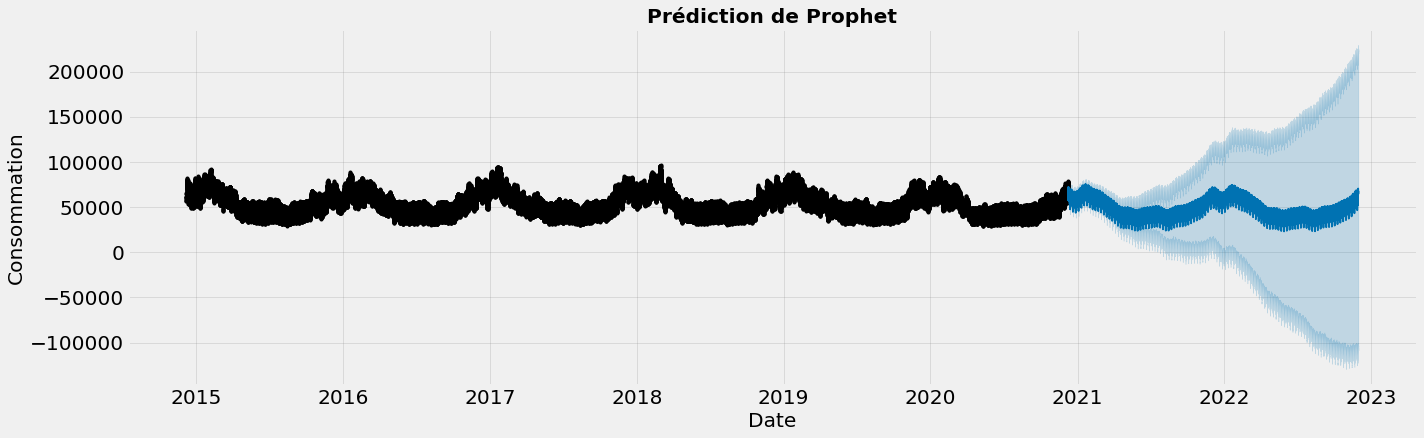

In [24]:
fig, ax = plt.subplots()
fig = model.plot(test_frc, ax=ax)
ax.set_title('Prédiction de Prophet')
plt.xlabel("Date")
plt.ylabel("Consommation")
plt.show()
#plt.savefig("predic_pro1.pdf")

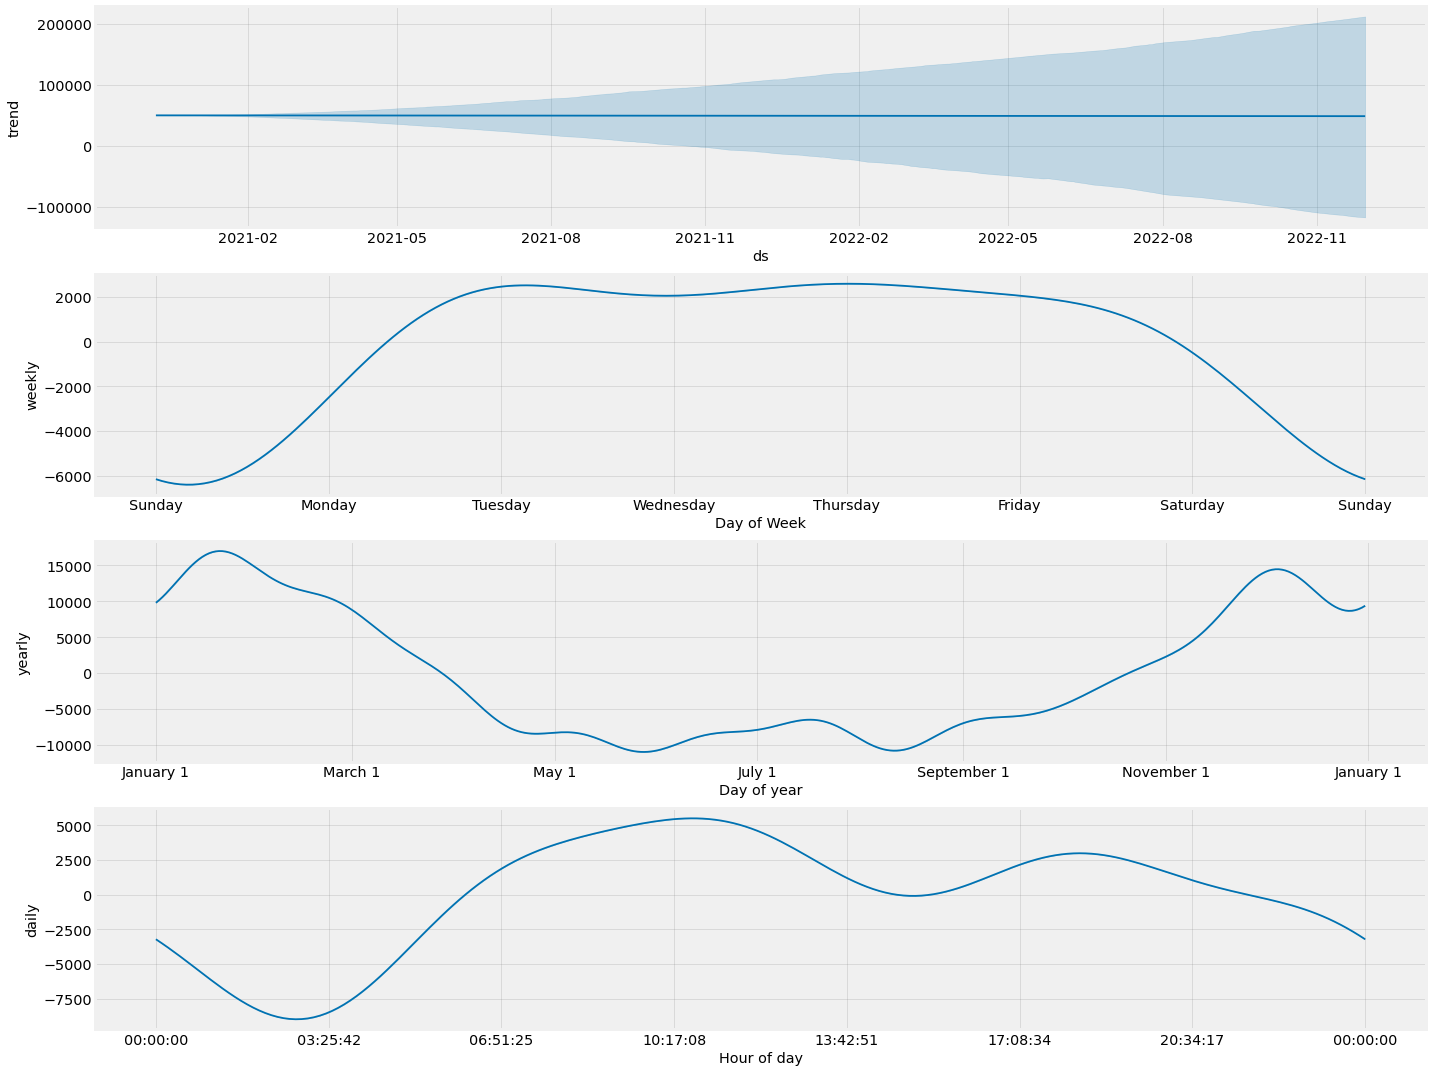

<Figure size 432x288 with 0 Axes>

In [57]:
#model components :
fig = model.plot_components(test_frc, figsize=(20,15))
plt.show()
#plt.savefig("components.pdf")

## 3- Comparaison de la prédiction aux vraies valeurs :

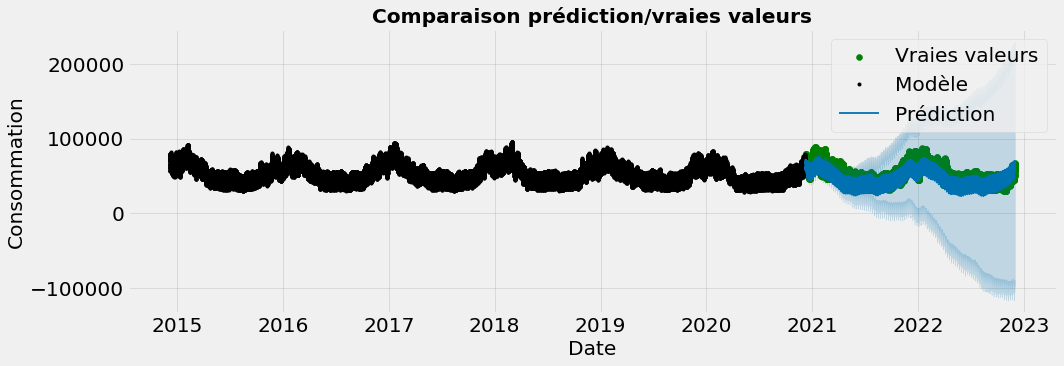

In [85]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test, color='g')
fig = model.plot(test_frc, ax=ax)
ax.set_title("Comparaison prédiction/vraies valeurs")
plt.xlabel("Date")
plt.ylabel("Consommation")
ax.legend(['Vraies valeurs', 'Modèle', 'Prédiction'])

## 4- Prise en compte de l'effet des vacances:

In [26]:
model_vac = Prophet(daily_seasonality = False)
model_vac.add_country_holidays(country_name='FR') #base de données des jours fériés 
model_vac.fit(train_pr)

20:06:10 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
# Predict on training set with model
frc_hol = model_vac.predict(test_pr)

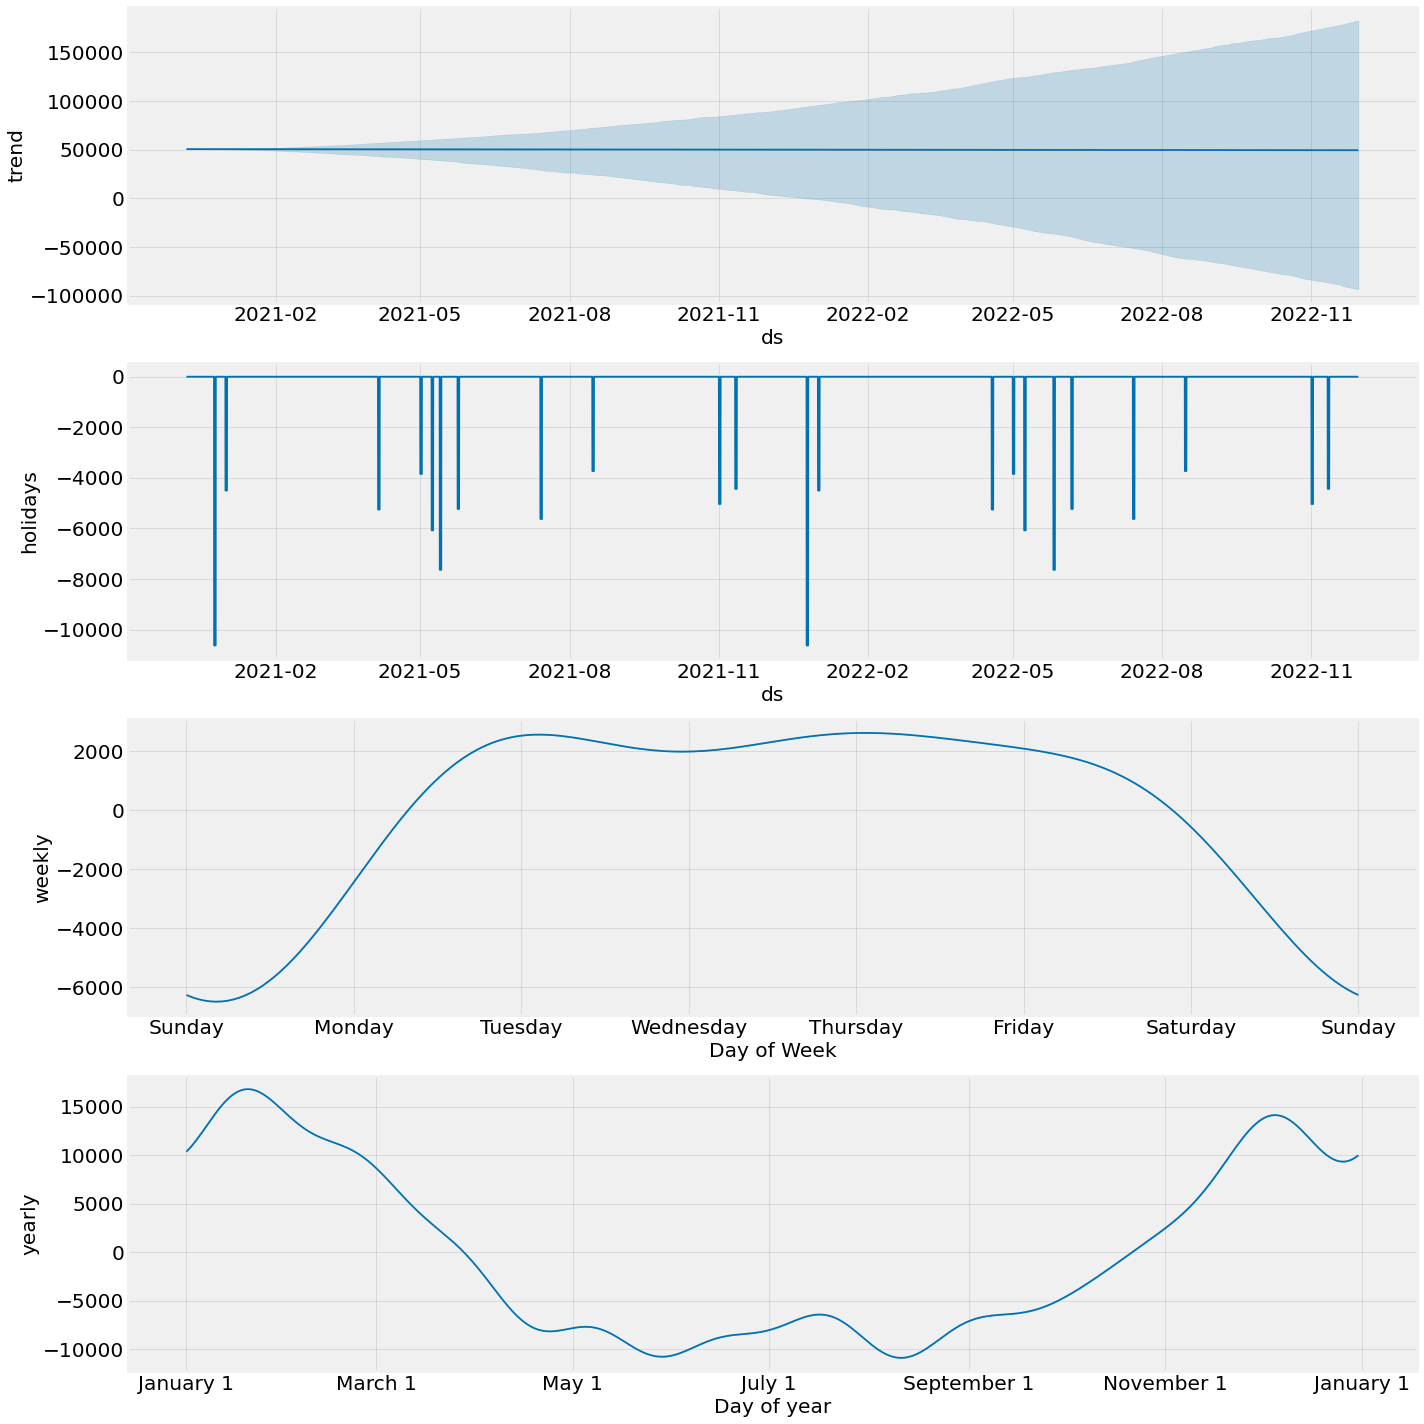

In [28]:
fig = model_vac.plot_components(frc_hol, figsize = (20,20))
plt.show()

### Comparaison du modèle avec les vraies données:

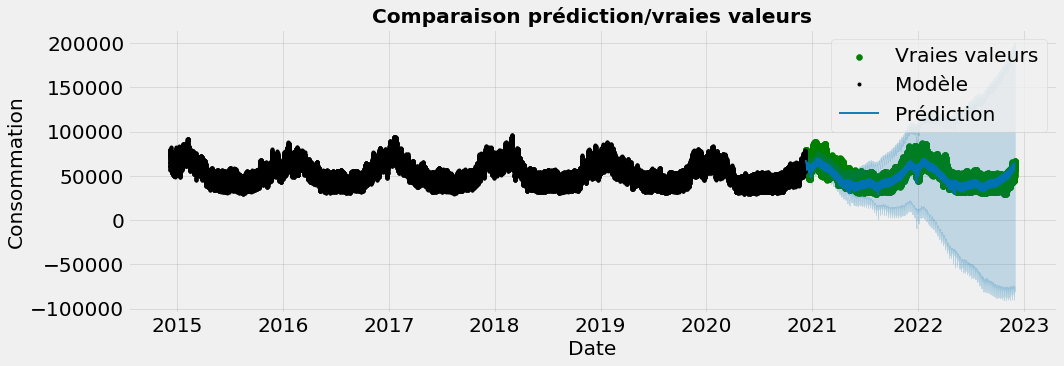

In [30]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize = (15, 5))
ax.scatter(test.index, test, color = 'g')
fig = model_vac.plot(frc_hol, ax = ax)
ax.set_title("Comparaison prédiction/vraies valeurs")
plt.xlabel("Date")
plt.ylabel("Consommation")
ax.legend(['Vraies valeurs', 'Modèle', 'Prédiction'])

In [31]:
future = model_vac.make_future_dataframe(periods = 2*48, freq = '30min', include_history = False)
forecast = model_vac.predict(future)

In [33]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Armistice 1918,Armistice 1918_lower,Armistice 1918_upper,Armistice 1945,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-08 00:00:00,50629.348682,59791.037157,74482.310391,50629.348682,50629.348682,0.0,0.0,0.0,0.0,...,2533.754435,2533.754435,2533.754435,13880.540551,13880.540551,13880.540551,0.0,0.0,0.0,67043.643667
1,2020-12-08 00:30:00,50629.315715,60126.551601,74662.179239,50629.315715,50629.315715,0.0,0.0,0.0,0.0,...,2546.762728,2546.762728,2546.762728,13877.253124,13877.253124,13877.253124,0.0,0.0,0.0,67053.331567
2,2020-12-08 01:00:00,50629.282748,59355.119914,74539.037357,50629.282748,50629.282748,0.0,0.0,0.0,0.0,...,2556.699504,2556.699504,2556.699504,13873.945698,13873.945698,13873.945698,0.0,0.0,0.0,67059.927950
3,2020-12-08 01:30:00,50629.249782,59856.990711,74558.059650,50629.249782,50629.249782,0.0,0.0,0.0,0.0,...,2563.693647,2563.693647,2563.693647,13870.618302,13870.618302,13870.618302,0.0,0.0,0.0,67063.561731
4,2020-12-08 02:00:00,50629.216815,60258.567308,74477.162269,50629.216815,50629.216815,0.0,0.0,0.0,0.0,...,2567.877996,2567.877996,2567.877996,13867.270968,13867.270968,13867.270968,0.0,0.0,0.0,67064.365778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-12-09 21:30:00,50626.348717,59612.022213,74578.938255,50626.348717,50626.348717,0.0,0.0,0.0,0.0,...,2599.532968,2599.532968,2599.532968,13503.637135,13503.637135,13503.637135,0.0,0.0,0.0,66729.518819
92,2020-12-09 22:00:00,50626.315750,59370.167454,74248.766472,50626.315750,50626.315750,0.0,0.0,0.0,0.0,...,2606.296417,2606.296417,2606.296417,13498.674721,13498.674721,13498.674721,0.0,0.0,0.0,66731.286889
93,2020-12-09 22:30:00,50626.282784,59418.000966,74574.787289,50626.282784,50626.282784,0.0,0.0,0.0,0.0,...,2612.107363,2612.107363,2612.107363,13493.695752,13493.695752,13493.695752,0.0,0.0,0.0,66732.085899
94,2020-12-09 23:00:00,50626.249817,59437.512944,74643.770055,50626.249817,50626.249817,0.0,0.0,0.0,0.0,...,2616.959957,2616.959957,2616.959957,13488.700272,13488.700272,13488.700272,0.0,0.0,0.0,66731.910046


Conclusion : les jours fériés n'ont pas un énorme impact sur notre prédiction, nous allons reprendre le modèle initial et l'utiliser pour faire nos prévisions. 

In [20]:
#Prédiction sur 10 jours à partir du 29 novembre :
m = Prophet() 
m.fit(df_cons) #ajuster notre modèle 'm' sur l'ensemble des données 
f = m.make_future_dataframe(periods=48*10 , freq='30min', include_history=False)
predic = m.predict(f)

18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:15:36 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
s = predic[['ds','yhat','yhat_lower','yhat_upper']] #la colonne 'yhat' contient les prédiction
s

,ds,yhat,yhat_lower,yhat_upper
0,2022-11-29 23:00:00,63209.474169,57911.827218,68748.699825
1,2022-11-29 23:30:00,62437.102703,56609.807993,67873.465709
2,2022-11-30 00:00:00,61424.199858,56104.315154,67296.256319
3,2022-11-30 00:30:00,60204.960318,54409.729332,65720.845764
4,2022-11-30 01:00:00,58886.317194,53382.007841,64160.205611
...,...,...,...,...
475,2022-12-09 20:30:00,64454.701841,58979.776946,69840.292604
476,2022-12-09 21:00:00,63793.633023,58620.034649,69211.307600
477,2022-12-09 21:30:00,63217.239533,57565.315718,68875.188484
478,2022-12-09 22:00:00,62692.163861,57070.872306,68251.789815


In [27]:
dataframe = pd.DataFrame(s)

In [37]:
#sélectionner les lignes qui correspondent à la prédiction pour le 8 décembre:
d = dataframe[len(s)-94:434]
d

,ds,yhat,yhat_lower,yhat_upper
386,2022-12-08 00:00:00,62770.965705,57346.920970,68357.663499
387,2022-12-08 00:30:00,61537.826296,56225.182534,66887.559749
388,2022-12-08 01:00:00,60203.408925,54602.522183,65590.527266
389,2022-12-08 01:30:00,58931.793802,53544.438018,64333.788040
390,2022-12-08 02:00:00,57912.608815,52765.694835,63608.306323
391,2022-12-08 02:30:00,57321.087115,52002.381684,62917.206921
392,2022-12-08 03:00:00,57279.569993,51829.152858,63270.028422
393,2022-12-08 03:30:00,57830.002156,52179.760790,63461.495434
394,2022-12-08 04:00:00,58924.211351,52964.456122,64466.527225
395,2022-12-08 04:30:00,60434.257955,54679.141523,65537.784485


In [41]:
predic_finale = d.rename(columns={'ds' : 'Date et heure', 'yhat' : 'Consommation (MW)', 'yhat_lower' : 'Consommation min', 'yhat_upper' : 'Consommation max'})

In [42]:
#Création du fichier .csv avec nos prédictions:
predic_finale.to_csv(path_or_buf='./prediction_8_dec.csv', sep=';')